***ML Algorithm to Cluster DeFi Pools***

The aim of this script is to create an algorith pipeline to cluster DeFi pools.

The script is divided in four parts:

1. Data Collection and Processing: The data is collected from the DeFi Llama API. As a first step, I will bring in the data. Additional new columns will need to be created such as the underlying token column, as well as creating the average APY over 7 and 30 days, the change in TVL over 7 and 30 days, standard deviation of APY over 7 and 30 days, and the standard deviation of TVL over 7 and 30 days.
2. Data Exploration: The data will be explored to understand the distribution of the data, and to understand the correlation between the different variables.
3. Machine Learning: The data will be clustered using K-Means clustering, hierarchical clustering, t-sne scatter plots. The optimal number of clusters will be determined using the elbow method.
4. Data Visualization: The data will be visualized using a scatter plot.



In [14]:
# importing all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
from fuzzywuzzy import process
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline



In [15]:
# Data Collection and Processing

# importing the data csv file
filepath = r'/Users/karolk/Python_Work/Data_Sets/Global_Data/DeFi_Global_DB.csv'
data = pd.read_csv(filepath, index_col=0)
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 4)
pd.options.display.float_format = '{:,.2f}'.format

In [16]:
# Data Transformation - Adding New Variables for Averages and Standard Deviations

#drop all pools that have a TVL of 0 or an APY of 0
data = data[(data['tvlUsd'] > 0) & (data['apy'] > 0)]

# use only the past 35 days of data for each pool. Defined as 35 days from analysis date below
analysis_date = '2023-12-15' # change the analysis date here
data['date'] = pd.to_datetime(data['date'])
data = data[data['date'] >= pd.to_datetime(analysis_date) - pd.DateOffset(days=35)]

#sort the data table by pool and by date
data = data.sort_values(['pool', 'date'], ascending=[True, True]).reset_index(drop=True)

# create 2 new columns to calculate the rolling average of the APY over 7 days and 30 days
data['7_day_rolling_apy'] = data.groupby('pool')['apy'].transform(lambda x: x.rolling(7, 1).mean())
data['30_day_rolling_apy'] = data.groupby('pool')['apy'].transform(lambda x: x.rolling(30, 1).mean())

# create 2 new columns to calculate the change in tvlUsd over 7 days and 30 days
data['7_day_change_tvlUsd'] = data.groupby(['pool'])['tvlUsd'].pct_change(periods=7) * 100
data['30_day_change_tvlUsd'] = data.groupby(['pool'])['tvlUsd'].pct_change(periods=30) * 100

# create 2 new columns to calculate the standard deviation of the APY over 7 days and 30 days
data['7_day_std_apy'] = data.groupby('pool')['apy'].transform(lambda x: x.rolling(7, 1).std())
data['30_day_std_apy'] = data.groupby('pool')['apy'].transform(lambda x: x.rolling(7, 1).std())

In [17]:
# Data Transformation - Adding new columns for the underlying tokens & taking only the most recent date

# for the purpose of this analysis, I will only use the data from the maximum date in the dataset
data = data[data['date'] == data['date'].max()]

# creating a list of all unique chains in the data set
chains = data['chain'].unique()

# create a list of all unique symbols in the data set
symbols = data['symbol'].unique()

# sort the symbols alphabetically
symbols.sort()

# splitting the 'symbol' column into 4 new columns using str.split() method with '-' as the separator
symbol_split = data['symbol'].str.split('-', expand=True, n=3)

# adding the 4 new columns to the data dataframe
symbol_split.columns = ['token_id_1', 'token_id_2', 'token_id_3', 'token_id_4']
data = pd.concat([data, symbol_split], axis=1)

# create a new column called num_tokens which is the number of tokens in the symbol
data['num_tokens'] = data['symbol'].str.count('-') + 1

# describe the data
display(data.describe())
# displaying chains
print(chains)


,tvlUsd,apy,apyMean30d,date,7_day_rolling_apy,30_day_rolling_apy,7_day_change_tvlUsd,30_day_change_tvlUsd,7_day_std_apy,30_day_std_apy,num_tokens
count,"10,474.00","10,474.00","10,474.00",10474,"10,474.00","10,474.00","9,435.00","8,079.00","10,360.00","10,360.00","10,474.00"
mean,"5,546,500.40",596.40,670.28,2024-02-04 00:00:00,769.64,839.15,33.05,20.73,261.35,261.35,1.87
min,"10,000.00",0.00,0.00,2024-02-04 00:00:00,0.00,0.00,-99.99,-99.68,0.00,0.00,1.00
25%,"26,124.75",1.40,3.29,2024-02-04 00:00:00,2.36,3.43,-5.81,-25.96,0.23,0.23,2.00
50%,"115,736.00",7.16,11.70,2024-02-04 00:00:00,9.31,11.98,-0.12,-9.75,1.63,1.63,2.00
75%,"563,257.50",28.70,48.78,2024-02-04 00:00:00,36.39,48.73,3.01,1.06,8.45,8.45,2.00
max,"21,841,355,151.00","143,870.78","442,367.39",2024-02-04 00:00:00,"471,104.68","471,104.68","136,162.66","37,337.08","448,402.94","448,402.94",11.00
std,"221,731,282.62","4,244.93","7,589.45",NaN,"6,989.13","7,163.82","1,762.84",504.23,"6,212.20","6,212.20",0.52


['Base' 'Ethereum' 'Sui' 'Avalanche' 'Arbitrum' 'Polygon zkEVM' 'Solana'
 'BSC' 'Optimism' 'Polygon' 'Defichain' 'Mantle' 'Osmosis' 'Manta' 'NEAR'
 'Fantom' 'Aurora' 'Cronos' 'Filecoin' 'Moonbeam' 'Astar' 'Heco' 'Metis'
 'Ton' 'Starknet' 'Celo' 'Aptos' 'Telos' 'Tezos' 'Tron' 'Nuls'
 'zkSync Era' 'MultiversX' 'Bitcoincash' 'Hedera' 'Rootstock' 'Moonriver'
 'Gnosis' 'Klaytn' 'Cardano' 'Kujira' 'Carbon' 'Ontology' 'Kava'
 'Persistence' 'Evmos' 'Cosmos' 'Algorand' 'Bifrost Network' 'Hydra'
 'Canto' 'Fuse' 'Rollux' 'Karura' 'Xdc' 'Kusama' 'Milkomeda C1' 'Linea'
 'Conflux' 'Vechain' 'Neo' 'Libre' 'Doge' 'Acala' 'Waves' 'Litecoin'
 'Obyte' 'Bifrost' 'Harmony' 'Polkadot' 'Bitcoin']


In [18]:
# Data Transformation - Adding new columns for whether pool is in top 10 chains, top 25 project

# create a table of the largest 10 chains by TVL
top_10_chains = data.groupby('chain')['tvlUsd'].sum().sort_values(ascending=False).head(10).reset_index()

# put the top 10 chains into a list
top_10_chains_list = top_10_chains['chain'].to_list()

# create a new column in the data dataframe to indicate whether the pool is in the top 10 chains
data['top_10_chain'] = np.where(data['chain'].isin(top_10_chains_list), 1, 0)

# create a table of the largest 25 projects by TVL
top_25_projects = data.groupby('project')['tvlUsd'].sum().sort_values(ascending=False).head(25).reset_index()

# put the top 25 projects into a list
top_25_projects_list = top_25_projects['project'].to_list()

# create a new column in the data dataframe to indicate whether the pool is in the top 25 projects
data['top_25_project'] = np.where(data['project'].isin(top_25_projects_list), 1, 0)

# convert the stablecoin column to be either 1 or 0 instead of True or False
data['stablecoin'] = np.where(data['stablecoin'] == True, 1, 0)


In [19]:
# Data Transformation - Creating Dataframe for Clustering, removing outliers and pools with less than 3 million in TVL and creating log columns

# create a new dataframe with only the columns that will be used for the clustering and the project, chain, pool and symbol columns
data_cluster = data[['project', 'chain', 'pool', 'symbol', 'tvlUsd',
                     '7_day_rolling_apy', '7_day_change_tvlUsd', 
                     '7_day_std_apy', 'top_10_chain', 'top_25_project', 'stablecoin', 'num_tokens']]

# selecting which chains to include in the clustering. The selection is based on a list of predefined chains.
chains_cluster = ['Ethereum']  # add chains here
data_cluster = data_cluster[data_cluster['chain'].isin(chains_cluster)]

# remove any outliers from the data by taking out any rows that are more than 3 standard deviations from the mean for the APY 7-day rolling average
data_cluster = data_cluster[np.abs(data_cluster['7_day_rolling_apy'] - 
                                   data_cluster['7_day_rolling_apy'].mean()) <= (3 * data_cluster['7_day_rolling_apy'].std())]

# remove any outliers from the data by taking out any rows that are more than 3 standard deviations from the mean for the change in TVL over 7 days
data_cluster = data_cluster[np.abs(data_cluster['7_day_change_tvlUsd'] - 
                                   data_cluster['7_day_change_tvlUsd'].mean()) <= (3 * data_cluster['7_day_change_tvlUsd'].std())]

# remove any outliers from the data by taking out any rows that are more than 3 standard deviations from the mean for the APY 7-day standard deviation
data_cluster = data_cluster[np.abs(data_cluster['7_day_std_apy'] - 
                                   data_cluster['7_day_std_apy'].mean()) <= (3 * data_cluster['7_day_std_apy'].std())]

# remove any outliers from the data by taking out any rows that are more than 3 standard deviations from the mean for the TVL
data_cluster = data_cluster[np.abs(data_cluster['tvlUsd'] - 
                                   data_cluster['tvlUsd'].mean()) <= (3 * data_cluster['tvlUsd'].std())]

# remove pools that are less than 3 million in TVL
data_cluster = data_cluster[data_cluster['tvlUsd'] >= 1000000]

# create a new column which is the log of the TVL
data_cluster['log_tvlUsd'] = np.log(data_cluster['tvlUsd'])

# create a new column which is the log of the 7-day rolling APY
data_cluster['log_7_day_rolling_apy'] = np.log(data_cluster['7_day_rolling_apy'])
                                               
# drop all rows that have a null value
data_cluster = data_cluster.dropna()

# describe the data
display(data_cluster.describe())


,tvlUsd,7_day_rolling_apy,7_day_change_tvlUsd,7_day_std_apy,top_10_chain,top_25_project,stablecoin,num_tokens,log_tvlUsd,log_7_day_rolling_apy
count,898.00,898.00,898.00,898.00,898.00,898.00,898.00,898.00,898.00,898.00
mean,"17,353,159.27",13.47,9.89,5.39,1.00,0.78,0.17,1.81,15.29,1.40
std,"67,393,792.62",30.71,219.83,18.23,0.00,0.41,0.38,0.54,1.31,1.95
min,"1,000,821.00",0.00,-66.17,0.00,1.00,0.00,0.00,1.00,13.82,-11.51
25%,"1,598,076.25",2.06,-3.17,0.21,1.00,1.00,0.00,1.00,14.28,0.72
50%,"3,027,716.50",5.39,0.00,0.86,1.00,1.00,0.00,2.00,14.92,1.69
75%,"7,698,807.00",12.99,2.49,3.25,1.00,1.00,0.00,2.00,15.86,2.56
max,"1,158,438,540.00",446.32,"6,542.81",234.16,1.00,1.00,1.00,5.00,20.87,6.10


/var/folders/gn/b1hbt5mx3mg2y8p3tgg7g7xh0000gn/T/ipykernel_10907/1778032346.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=data_cluster, x='log_7_day_rolling_apy', y='log_tvlUsd', palette='mako_r')


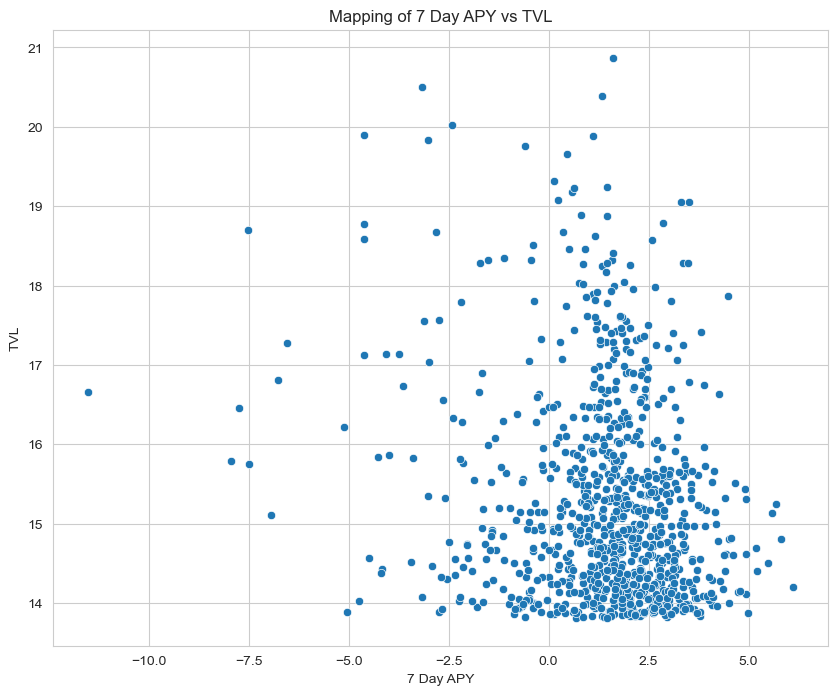

In [20]:
# Data Visualization - creating a scatter plot using seaborn to visualize the data prior to clustering

# create a scatter plot using seaborn with the x-axis being the 7-day APY and the y-axis being the TVL
sns.scatterplot(data=data_cluster, x='log_7_day_rolling_apy', y='log_tvlUsd', palette='mako_r')

#setting the title and axis labels
plt.title('Mapping of 7 Day APY vs TVL')
plt.xlabel('7 Day APY')
plt.ylabel('TVL')

# setting the size of the plot
plt.rcParams['figure.figsize'] = [10, 8]

# show the plot
plt.show()


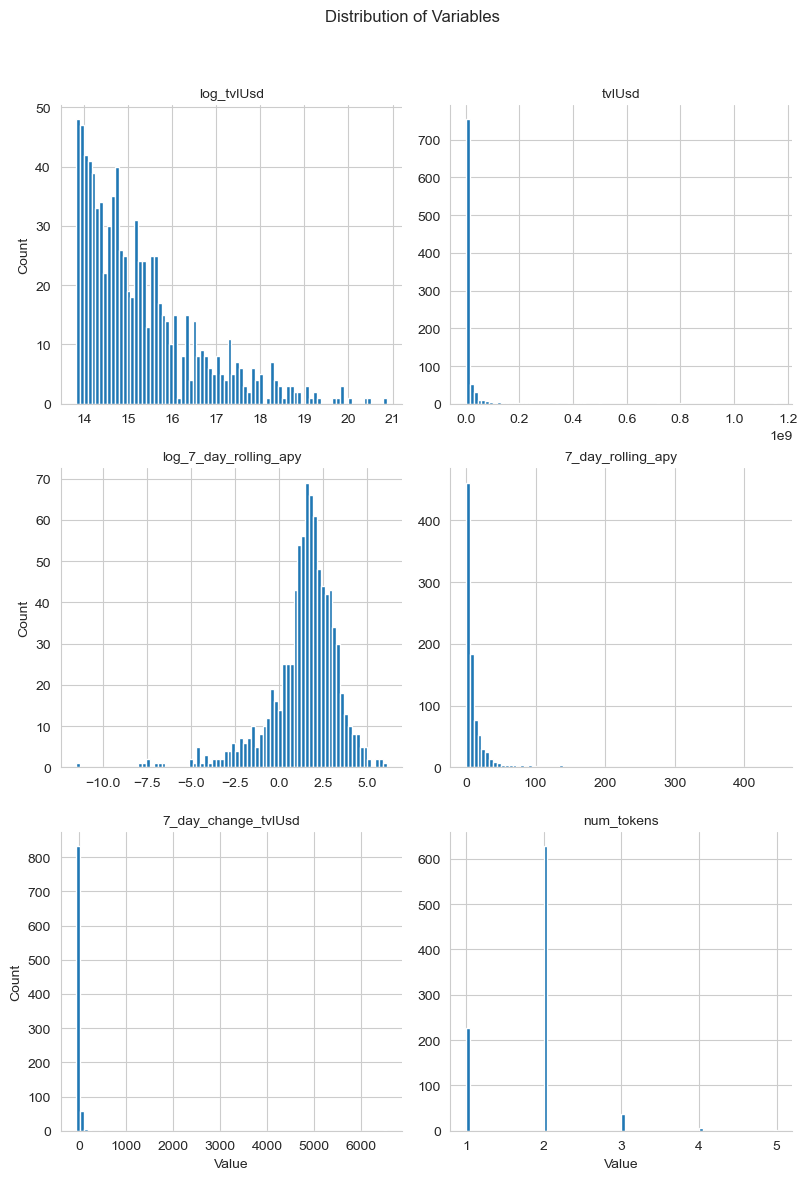

In [21]:
# Data Visualization - creating a facet grid using seaborn to visualize the data prior to clustering. I will use histograms to visualize the distribution of the data for each variable

# selecting data to visualize
data_facetgrid = data_cluster[['log_tvlUsd', 'tvlUsd', 
                               'log_7_day_rolling_apy', '7_day_rolling_apy', 
                               '7_day_change_tvlUsd', 'num_tokens']]


# melting the data to create a long dataframe with 2 columns: variable and value
data_facetgrid = pd.melt(data_facetgrid, 
                         var_name='variable', 
                         value_name='value')

# creating a facet grid with seaborn
g = sns.FacetGrid(data_facetgrid, col='variable', col_wrap=2, height=4, sharey=False, sharex=False)
g.map(plt.hist, 'value', bins=80) # adjust bin number here as needed

# setting the title and axis labels
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of Variables')
g.set_titles('{col_name}')

# adding labels to the x-axis and y-axis
g.set_axis_labels(x_var='Value', y_var='Count')

# show the plot
plt.show()

In [22]:
# Data Exploration - Describing the Data and Viewing the Data

# describe the data
display(data_cluster.describe())
display(data_cluster.info())



,tvlUsd,7_day_rolling_apy,7_day_change_tvlUsd,7_day_std_apy,top_10_chain,top_25_project,stablecoin,num_tokens,log_tvlUsd,log_7_day_rolling_apy
count,898.00,898.00,898.00,898.00,898.00,898.00,898.00,898.00,898.00,898.00
mean,"17,353,159.27",13.47,9.89,5.39,1.00,0.78,0.17,1.81,15.29,1.40
std,"67,393,792.62",30.71,219.83,18.23,0.00,0.41,0.38,0.54,1.31,1.95
min,"1,000,821.00",0.00,-66.17,0.00,1.00,0.00,0.00,1.00,13.82,-11.51
25%,"1,598,076.25",2.06,-3.17,0.21,1.00,1.00,0.00,1.00,14.28,0.72
50%,"3,027,716.50",5.39,0.00,0.86,1.00,1.00,0.00,2.00,14.92,1.69
75%,"7,698,807.00",12.99,2.49,3.25,1.00,1.00,0.00,2.00,15.86,2.56
max,"1,158,438,540.00",446.32,"6,542.81",234.16,1.00,1.00,1.00,5.00,20.87,6.10


<class 'pandas.core.frame.DataFrame'>
Index: 898 entries, 1208 to 850631
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   project                898 non-null    object 
 1   chain                  898 non-null    object 
 2   pool                   898 non-null    object 
 3   symbol                 898 non-null    object 
 4   tvlUsd                 898 non-null    float64
 5   7_day_rolling_apy      898 non-null    float64
 6   7_day_change_tvlUsd    898 non-null    float64
 7   7_day_std_apy          898 non-null    float64
 8   top_10_chain           898 non-null    int64  
 9   top_25_project         898 non-null    int64  
 10  stablecoin             898 non-null    int64  
 11  num_tokens             898 non-null    int64  
 12  log_tvlUsd             898 non-null    float64
 13  log_7_day_rolling_apy  898 non-null    float64
dtypes: float64(6), int64(4), object(4)
memory usage: 105.2+ K

None

In [23]:
# k-means clustering. Finding the optimal number of clusters using the elbow method defined in the function below.

def find_optimal_clusters(sample, start_clusters=1, end_clusters=10, interval=1):
    """
    Use the elbow method to find the optimal number of clusters for k-means.

    Parameters:
    - data: DataFrame, the input data for clustering.
    - features: list, the list of feature columns used for clustering.
    - start_clusters: int, the starting number of clusters.
    - end_clusters: int, the ending number of clusters.
    - interval: int, the interval at which the number of clusters should change.

    Returns:
    - None, but it plots the elbow curve.
    """
    cluster_sample = sample

    # standardize the data using the StandardScaler() method
    scaler = StandardScaler()
    cluster_sample_scaled = scaler.fit_transform(cluster_sample)

    # Calculate inertia for different values of k
    inertias = []
    cluster_range = range(start_clusters, end_clusters + 1, interval)
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        pipeline = make_pipeline(scaler, kmeans)
        pipeline.fit(cluster_sample)
        inertias.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(8, 6))
    plt.plot(cluster_range, inertias, marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()



/Users/karolk/anaconda3/envs/ML_Price/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/karolk/anaconda3/envs/ML_Price/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/karolk/anaconda3/envs/ML_Price/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/karolk/anaconda3/envs/ML_Price/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: Fut

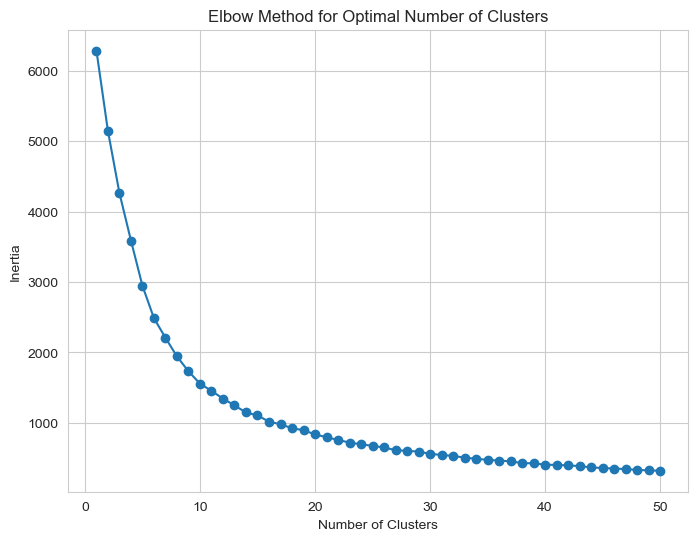

In [24]:
# k-means clustering. using the function defined above to find the optimal number of clusters

# define the cluster sample
cluster_sample = data_cluster[['log_7_day_rolling_apy', 'log_tvlUsd', 
                               '7_day_change_tvlUsd', '7_day_std_apy', 
                               'top_10_chain', 'top_25_project', 'stablecoin', 'num_tokens']]
# use the function defined above to find the optimal number of clusters
find_optimal_clusters(cluster_sample, start_clusters=1, end_clusters=50, interval=1)


/Users/karolk/anaconda3/envs/ML_Price/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Model Inertia: 1105.016


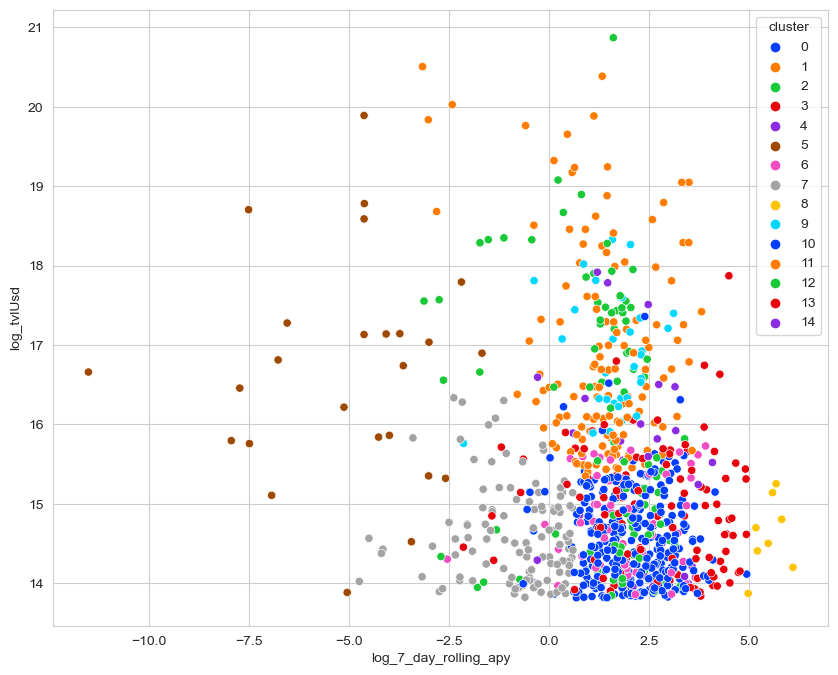

In [25]:
# k-means clustering. 
# create a new dataframe with only the columns that will be used for the clustering
cluster_sample = data_cluster[['log_7_day_rolling_apy', 'log_tvlUsd',
                               '7_day_change_tvlUsd', '7_day_std_apy',
                               'top_10_chain', 'top_25_project', 'stablecoin', 'num_tokens']]

# standardize the data using the StandardScaler() method
scaler = StandardScaler()
StandardScaler(copy=True, with_mean=True, with_std=True)
cluster_sample_scaled = scaler.fit_transform(cluster_sample)

# define the k-means model
kmeans = KMeans(n_clusters=15, random_state=42) # change the number of clusters here

# make a pipeline with the scaler and the k-means model
pipeline = make_pipeline(scaler, kmeans)

# fit the pipeline to the data
pipeline.fit(cluster_sample)

# predict the cluster labels
labels = pipeline.predict(cluster_sample)

# create a new column in the data dataframe with the cluster labels
data_cluster['cluster'] = labels

# print the model inertia with the text Model Inertia: and the model inertia, inertia should be with 3 decimal places.
print('Model Inertia: {:.3f}'.format(kmeans.inertia_))

# Visualize the clusters using a scatter plot (seaborn) with the x-axis being the APY and the y-axis being the TVL
sns.scatterplot(data=data_cluster, x='log_7_day_rolling_apy', y='log_tvlUsd', hue='cluster', palette='bright')
plt.show()

,7_day_change_tvlUsd,7_day_rolling_apy,7_day_std_apy,num_tokens,stablecoin,top_25_project,tvlUsd
cluster,,,,,,,
0,4.22,10.75,4.55,1.97,0.00,1.00,"2,258,357.27"
1,1.19,7.02,1.98,1.81,0.00,1.00,"14,839,715.33"
2,0.27,9.62,1.02,1.16,1.00,0.00,"5,824,813.60"
3,2.69,6.77,0.90,2.02,1.00,0.98,"3,902,759.02"
4,"6,542.81",5.25,4.11,2.00,0.00,1.00,"1,331,220.00"
5,1.25,0.03,0.00,1.12,0.00,0.72,"46,837,027.60"
6,2.86,11.74,0.51,1.00,0.00,0.00,"3,080,046.27"
7,0.06,0.72,0.48,1.96,0.00,1.00,"2,813,183.59"
8,3.92,261.32,167.12,1.88,0.00,0.88,"2,423,261.25"


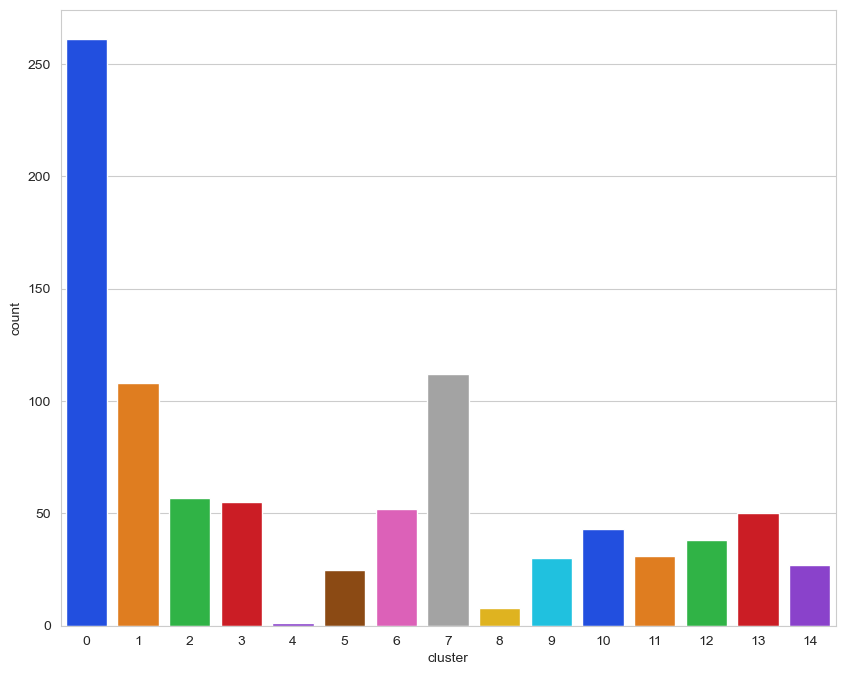

,project,chain,pool,symbol,tvlUsd,7_day_rolling_apy,7_day_change_tvlUsd,7_day_std_apy,top_10_chain,top_25_project,stablecoin,num_tokens,log_tvlUsd,log_7_day_rolling_apy,cluster
51598,thorchain,Ethereum,0fbb8455-2846-4bc3-8901-50a4bbb9e93c,USDC,"4,692,024.00",6.84,-12.41,0.24,1,1,1,1,15.36,1.92,3
62866,sommelier,Ethereum,12d235e5-e7b2-49cc-a5a9-4d14926f6e92,USDC-USDT-DAI,"1,642,952.00",6.92,0.31,5.78,1,0,1,3,14.31,1.93,3
68945,uniswap-v3,Ethereum,14683a89-ca7f-4e9a-9655-905d570d7968,GRAI-USDC,"5,733,550.00",0.53,-8.18,0.56,1,1,1,2,15.56,-0.64,3
82014,pendle,Ethereum,18860df8-ce80-4c27-a048-c60f6417eda9,EUSD,"1,061,460.00",9.81,-50.61,3.25,1,1,1,1,13.88,2.28,3
121644,curve-dex,Ethereum,2563e1a8-a8da-4b8d-9598-ece8028b95ec,EURS-SEUR,"1,892,519.00",0.12,-0.21,0.07,1,1,1,2,14.45,-2.14,3
122219,curve-dex,Ethereum,257941f5-0b07-47f0-853c-b4cc656a4f8b,AGEUR-EURT-EURS,"2,279,984.00",3.59,8.18,0.25,1,1,1,3,14.64,1.28,3
131426,uniswap-v3,Ethereum,28749923-7a19-4d25-9a23-5d9da6242d82,AGEUR-USDC,"3,766,990.00",0.49,8.88,0.32,1,1,1,2,15.14,-0.71,3
152596,curve-dex,Ethereum,2faacc5b-7e32-46f3-84e2-061aed8f7f21,HYUSD-EUSD,"3,252,833.00",8.51,-3.02,0.21,1,1,1,2,15.00,2.14,3
154528,convex-finance,Ethereum,30339b96-be67-45e5-87cb-adcd91049803,ADAI-AUSDC-AUSDT,"4,656,373.00",5.42,-0.85,0.83,1,1,1,3,15.35,1.69,3
188765,curve-dex,Ethereum,3a745337-3f04-409d-9627-8391e3c7494d,DOLA-FRAXBP,"9,390,513.00",8.23,4.90,0.27,1,1,1,2,16.06,2.11,3


In [26]:
# k-means clustering. Cluster deep dive - using a pivot table to see the mean values for each variable grouping by cluster

# create a pivot table with the mean values for each variable grouped by cluster
cluster_pivot = data_cluster.pivot_table(index='cluster', values=['7_day_rolling_apy', 'tvlUsd', '7_day_change_tvlUsd',
                                                                  '7_day_std_apy', 'top_25_project', 'stablecoin', 'num_tokens'])
# display the pivot table
display(cluster_pivot)

# viewing the number of pools in each cluster using a countplot (seaborn)
sns.countplot(data=data_cluster, x='cluster', palette='bright')
plt.show()

# viewing the pools in each cluster using a dataframe where the input is the cluster number
cluster_members = data_cluster[data_cluster['cluster'] == 3] # change the cluster number here

# display the cluster members
cluster_members